In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [6]:
# I removed all NaN for simplicity

R = pd.read_csv('logret_russel1000_pairtrad.csv',index_col=0)

In [7]:
R.columns.shape

(50,)

In [8]:
tin = 252

In [9]:
# log-prices

P = R.cumsum(axis=0).T.values

In [10]:
R = R.values.T

In [11]:
#in-sample out-of-sample
Pin,Pout = P[:,:tin],P[:,tin:]
Rin,Rout = R[:,:tin],R[:,tin:]

In [12]:
# Select I(1) process. Non significant adfuller on price, and sigificant on returns (fit differences)
sel = np.array( [i for i in range(len(Pin)) if (adfuller(Rin[i])[1]<0.01) and adfuller(Pin[i])[1]>0.01] ) 

Pin[sel],Rin[sel] = Pin[sel],Rin[sel]
Pout[sel],Rout[sel] = Pout[sel],Rout[sel]

In [13]:
len(sel)

50

In [47]:
print(Pin)

[[-0.0387735  -0.07187348 -0.1085971  ... -0.04812662 -0.04330768
  -0.03135992]
 [-0.03616525 -0.07133743 -0.05503913 ...  0.2092774   0.23076472
   0.25180014]
 [-0.0141553  -0.03058322 -0.02233556 ...  0.40338767  0.41603749
   0.38770681]
 ...
 [-0.02400357 -0.06146631 -0.06488053 ... -0.76930747 -0.78237952
  -0.82539686]
 [ 0.00899169  0.00771209  0.00899169 ...  0.1637944   0.0893183
   0.09957489]
 [-0.03361666 -0.05230875 -0.04796452 ... -0.11062416 -0.12179734
  -0.08091101]]


In [14]:
N = len(Pin)

In [15]:
# Compute cointegration p-values
C = sorted([(coint(Pin[i],Pin[j])[1],(i,j)) for i in range(N) for j in range(N) if i!=j])

In [45]:
#Bonferroni selection
thr = 0.01/len(C)
print(thr)
pairs = list( filter(lambda x: x[0]<thr,C) )

4.081632653061224e-06


In [17]:
print(pairs)

[(1.540647334845489e-06, (45, 2)), (2.5786176676957097e-06, (2, 45))]


In [18]:
# Select one of the cointegrated pair
i,j = pairs[0][1]

Text(0.5, 1.0, 'in-sample')

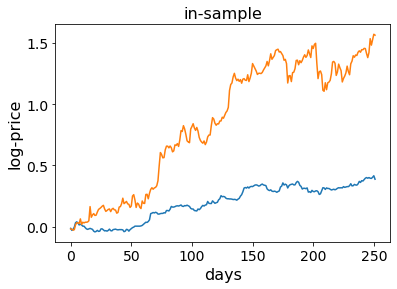

In [19]:
# Visual representation of the log-price of the selected stocks
plt.plot(Pin[j])
plt.plot(Pin[i])
plt.tick_params(labelsize=14)
plt.xlabel('days',fontsize=16)
plt.ylabel('log-price',fontsize=16)
plt.title('in-sample',fontsize=16)

In [20]:
# Linear regression of j on i
rgfit = LinearRegression().fit(Pin[j][np.newaxis].T,Pin[i])

rgVar = rgfit.predict(Pin[j][np.newaxis].T)

Text(0.5, 1.0, 'in-sample')

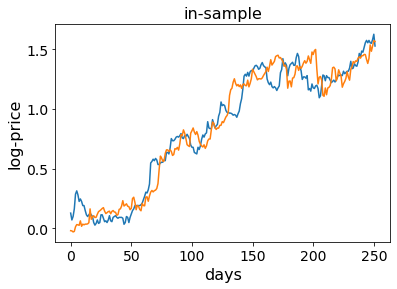

In [21]:
# Visual representation of the log-price of one stock and the regression of the other
plt.plot(rgVar)
plt.plot(Pin[i])
plt.tick_params(labelsize=14)
plt.xlabel('days',fontsize=16)
plt.ylabel('log-price',fontsize=16)
plt.title('in-sample',fontsize=16)

In [22]:
# residue of the regression
u = Pin[i]-rgVar

Text(0.5, 1.0, 'in-sample')

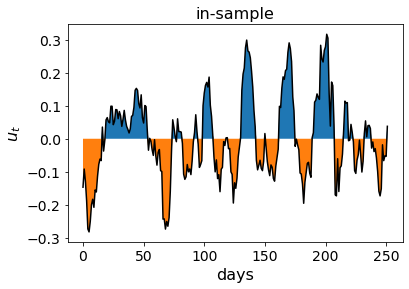

In [23]:
# Visual representation of te regression variable
plt.plot(u,color='k')
plt.fill_between(range(tin),0,np.clip(u,0,np.inf))
plt.fill_between(range(tin),np.clip(u,-np.inf,0),0)
plt.xlabel('days',fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel(r'$u_t$',fontsize=16)
plt.title('in-sample',fontsize=16)

In [24]:
# Here we start the characterization of the ARMA(p,q) as TD2

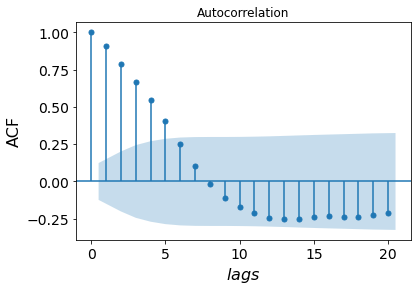

In [25]:
sm.graphics.tsa.plot_acf(u, lags=20)
plt.xlabel(r'$lags$',fontsize=16)
plt.ylabel('ACF',fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

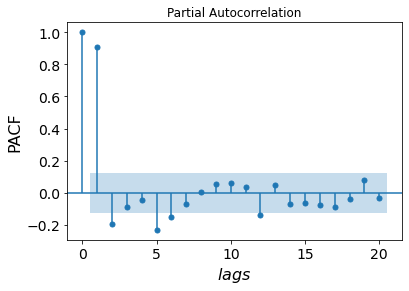

In [26]:
sm.graphics.tsa.plot_pacf(u, lags=20)
plt.xlabel(r'$lags$',fontsize=16)
plt.ylabel('PACF',fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

In [27]:
models = [(1,1),
          (2,1),
          (1,2),
          (2,2)] 
#No pure AR or MA unless you want to include extreamly large lags (252 days are not a lot)

In [28]:
M = {}
for p,q in models:
    try:
        #fit an arma (for now without trend)
        ft = ARMA(u,order=(p,q)).fit(method='mle')
        M[p,q] = ft
    except ValueError:
        print(p,q,'Maybe not stationary')

d:\CS_1A\ST4\Données statistiques en finance\TDs\FiEnv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
d:\CS_1A\ST4\Données statistiques en finance\TDs\FiEnv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmo

In [29]:
AIC = pd.DataFrame( [(m,ft.aic) for m,ft in M.items()],columns=['model','AIC'] ) 

AIC = AIC.assign(dAIC=(AIC.AIC-AIC.AIC.min()))

AIC

,model,AIC,dAIC
0,"(1, 1)",-770.311424,9.798822
1,"(2, 1)",-780.110246,0.000000
2,"(1, 2)",-770.993416,9.116830


In [30]:
#ARMA(2,1) seems the only good model.

In [31]:
p,q = AIC.model[1]

In [32]:
M[p,q].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:                     ARMA(2, 1)   Log Likelihood                 395.055
Method:                           mle   S.D. of innovations              0.050
Date:                Thu, 13 May 2021   AIC                           -780.110
Time:                        17:14:48   BIC                           -762.463
Sample:                             0   HQIC                          -773.009
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.014      0.270      0.788      -0.024       0.032
ar.L1.y        1.8285      0.059     31.133      0.000       1.713       1.944
ar.L2.y       -0.8663      0.051    -16.879      0.000      -0.967      -0.766
ma.L1.y       -0.8306      0.082    -10.151      0.000      -0.991      -0.670
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0553           -0.2016j            1.0744           -0.0300
AR.2            1.0553           +0.2016j            1.0744            0.0300
MA.1            1.2040           +0.0000j            1.2040            0.0000
-----------------------------------------------------------------------------
"""

In [33]:
#All the coefficient are significant

In [34]:
r = M[p,q].resid

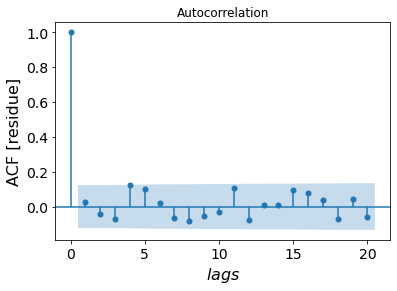

In [35]:
sm.graphics.tsa.plot_acf(r, lags=20)
plt.xlabel(r'$lags$',fontsize=16)
plt.ylabel('ACF [residue]',fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

In [36]:
acorr_ljungbox(r,lags=p+q+5,model_df=p+q,return_df=True)

,lb_stat,lb_pvalue
1,0.180975,NaN
2,0.611051,NaN
3,1.932390,NaN
4,5.960337,0.014631
5,8.495478,0.014297
6,8.585286,0.035344
7,9.692461,0.045939
8,11.402507,0.043958


In [37]:
#It is on the limit to be accepted (small p-value)

In [38]:
#Now let us look at the out-of-sample persistence

In [39]:
# Evaluate the regression with the same parameters obtained in-sample
rgVar = rgfit.predict(P[j][np.newaxis].T)

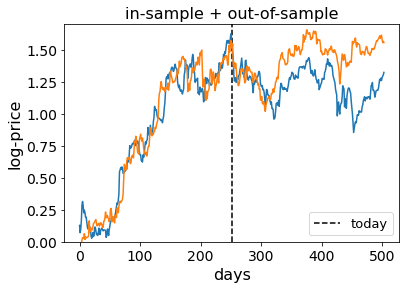

In [40]:
# It seems that after a month the cointegration is lost
plt.plot(rgVar)
plt.plot(P[i])
plt.vlines(tin,0,1.7,ls='--',color='k',label='today')
plt.ylim([0,1.7])
plt.xlabel('days',fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel(r'log-price',fontsize=16)
plt.title('in-sample + out-of-sample',fontsize=16)
plt.legend(loc='lower right',fontsize=13)

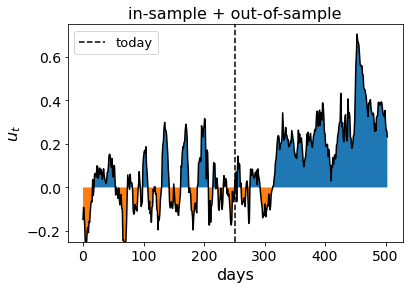

In [41]:
# The residue of the regression show a very large positive run which is probably incompatible with ARMA(2,1)
u =  (P[i]-rgVar) 
plt.plot(u,color='k')
plt.vlines(tin,-0.25,0.75,ls='--',color='k',label='today')

plt.fill_between(range(2*tin),0,np.clip(u,0,np.inf))
plt.fill_between(range(2*tin),np.clip(u,-np.inf,0),0)
plt.ylim([-0.25,0.75])
plt.xlabel('days',fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel(r'$u_t$',fontsize=16)
plt.title('in-sample + out-of-sample',fontsize=16)
plt.legend(loc='upper left',fontsize=13)

In [42]:
# On the out-of-sample there is no overfitting so we can use adfuller

In [43]:
adfuller( (P[i]-rgVar)[tin:] )

(-2.237799619670746,
 0.19281342648624006,
 0,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 -817.3541478587906)

In [44]:
# we cannot guarantee that in the out-of-sample is stationary